<font face="Tahoma" size=5 color=#000000> import packages and data

In [132]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import random
import matplotlib.pyplot as plt

In [133]:
# import processed data 
new_train = pd.read_csv('we_data/new_train.csv')
new_validation = pd.read_csv('we_data/new_validation.csv')
new_test = pd.read_csv('we_data/new_test.csv')

In [134]:
# import test data
train = pd.read_csv('we_data/train.csv')
validation = pd.read_csv('we_data/validation.csv')
test = pd.read_csv('we_data/test.csv')

<font face="Tahoma" size=5 color=#000000> Opponent Simulation

In [135]:
def LinearStrategy(pCTR, base_bid,avgCTR):
    avgCTR = np.repeat(avgCTR*100, pCTR.shape[0])
    base_bid =  np.repeat(base_bid, pCTR.shape[0])
    bidprices  = (base_bid * pCTR['pCTR'])/ avgCTR
    return bidprices

In [136]:
def Non_LinearStrategy(pCTR,avgCTR,base_bid,m,n):
    avgCTR = np.repeat(avgCTR*100, pCTR.shape[0])
    base_bid =  np.repeat(base_bid, pCTR.shape[0])
    m= np.repeat(m, pCTR.shape[0])
    n= np.repeat(n, pCTR.shape[0])
    bidprices  =  base_bid  * ((pCTR['pCTR']/ avgCTR)**2) + m* (pCTR['pCTR']/ avgCTR) + n
    return bidprices

In [292]:
# get the opponent bid
vali_1 = pd.read_csv('we_data/opponent_bid/vali_1.csv')['bidprice'].values
vali_2 = pd.read_csv('we_data/opponent_bid/vali_2.csv')['bidprice'].values
vali_3 = pd.read_csv('we_data/opponent_bid/vali_3.csv')['bidprice'].values
vali_4 = pd.read_csv('we_data/opponent_bid/vali_4.csv')['bidprice'].values
vali_5 = pd.read_csv('we_data/opponent_bid/vali_5.csv')['bidprice'].values

# new_vali1 = pd.read_csv('we_data/opponent_bid/new_vali1.csv')['bidprice'].values
# new_vali2 = pd.read_csv('we_data/opponent_bid/new_vali2.csv')['bidprice'].values
# new_vali3 = pd.read_csv('we_data/opponent_bid/new_vali3.csv')['bidprice'].values
# new_vali4 = pd.read_csv('we_data/opponent_bid/new_vali4.csv')['bidprice'].values
# new_vali5 = pd.read_csv('we_data/opponent_bid/new_vali5.csv')['bidprice'].values



def Evaluate(validation, pre_bidprices):#, vali_1 = new_vali1, vali_2 = new_vali2, vali_3 = new_vali3, vali_4 = new_vali4, vali_5 = new_vali5):
    
    bidprice = pre_bidprices
    budget = 6250000

    #find who wins the bid
    payprice = validation['payprice'].values
    win_bid = (bidprice>payprice) & (bidprice>vali_1) & (bidprice>vali_2) & (bidprice>vali_3)  & (bidprice>vali_4) & (bidprice>vali_5) 

    spend = np.cumsum(payprice*win_bid)
    enough_budget = spend<budget


    click =  np.sum(validation['click'].values*win_bid*enough_budget)
    impression = np.sum(win_bid*enough_budget)
    spend = np.max(spend*enough_budget)
    ctr = click/impression*100
    cpm = spend/impression*1000
    cpc = spend/click


    return [impression,click, ctr, spend, cpm, cpc]

In [293]:
def plot(results):

    plt.figure(figsize = (20,8))

    plt.subplot(2,3,1)
    plt.plot(results['basebid'], results["click"])
    plt.xlabel("Base Bid")
    plt.ylabel("click")

    plt.subplot(2,3,2)
    plt.plot(results['basebid'], results["ctr"])
    plt.xlabel("Base Bid")
    plt.ylabel("ctr")


    plt.subplot(2,3,3)
    plt.plot(results['basebid'], results["spend"])
    plt.xlabel("Base Bid")
    plt.ylabel("spend")

    plt.subplot(2,3,4)
    plt.plot(results['basebid'], results["cpm"])
    plt.xlabel("Base Bid")
    plt.ylabel("cpm")


    plt.subplot(2,3,5)
    plt.plot(results['basebid'], results["cpc"])       
    plt.xlabel("Base Bid")
    plt.ylabel("cpc")

In [296]:
# k=0
# results  = pd.DataFrame(columns = ["basebid","impression","click","ctr","spend","cpm","cpc"])     

# basebids = np.linspace(100, 350, 20)
# avgCTR= 0.0007375623256619447
# XG_validation = pd.read_csv('we_data/XG_validation.csv') # using XGboosting to predict the CTR


# for basebid in basebids:
#     for m in range(100, 150, 10):
#         for n in range(1,5,1):
#             pre_bidprices = Non_LinearStrategy(pCTR =XG_validation,avgCTR = avgCTR, base_bid = basebid,m=m,n=n)
#             impression, click, ctr, spend, cpm, cpc = Evaluate(validation, pre_bidprices)
#             results.loc[k]  = np.round(basebid,5) , impression, click, ctr, spend, cpm, cpc
#             k = k+1
            
            
            
k=0
results  = pd.DataFrame(columns = ["basebid","impression","click","ctr","spend","cpm","cpc","m","n"])     

basebids = range(100, 700, 10)
range_m = range(25, 50, 5)
range_n = range(2, 5, 1)

# basebids = [450]
# range_m = [35]
# range_n = [3]

avgCTR= 0.0007375623256619447
XG_validation = pd.read_csv('we_data/XG_validation.csv') # using XGboosting to predict the CTR

for basebid in basebids:   
    for m in range_m:
        for n in range_n:
            pre_bidprices = Non_LinearStrategy(XG_validation,avgCTR, basebid,m,n)
            impression, click, ctr, spend, cpm, cpc = Evaluate(validation, pre_bidprices)
            results.loc[k]  = np.round(basebid,5) , impression, click, ctr, spend, cpm, cpc, m, n
            k = k+1

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [298]:
results

,basebid,impression,click,ctr,spend,cpm,cpc,m,n
0,100.0,10812.0,109.0,1.008139,903678.0,83581.021088,8290.623853,25.0,2.0
1,100.0,10889.0,109.0,1.001010,910611.0,83626.687483,8354.229358,25.0,3.0
2,100.0,10943.0,109.0,0.996071,916097.0,83715.343142,8404.559633,25.0,4.0
3,100.0,11352.0,109.0,0.960183,954986.0,84124.911910,8761.339450,30.0,2.0
4,100.0,11412.0,109.0,0.955135,959715.0,84097.003155,8804.724771,30.0,3.0
5,100.0,11475.0,109.0,0.949891,965685.0,84155.555556,8859.495413,30.0,4.0
6,100.0,11944.0,110.0,0.920965,1007172.0,84324.514401,9156.109091,35.0,2.0
7,100.0,12023.0,110.0,0.914913,1013566.0,84302.254013,9214.236364,35.0,3.0
8,100.0,12112.0,110.0,0.908190,1021148.0,84308.784676,9283.163636,35.0,4.0
9,100.0,12561.0,110.0,0.875726,1062952.0,84623.198790,9663.200000,40.0,2.0


In [301]:
basebid =  results.loc[(results['click'] == results.click.max())]['n'].values
basebid

array([4., 3., 4., 3., 2., 2., 4., 3., 3.])

In [310]:
### get our bid price
XG_test = pd.read_csv('we_data/XG_test.csv') # using XGboosting to predict the CTR
base_bid = 450
m = 40
n = 3

results  = pd.DataFrame(columns = ["basebid","m","n","impression","click","ctr","spend","cpm","cpc"])     
impression, click, ctr, spend, cpm, cpc = Evaluate(validation, pre_bidprices)
results.loc[k]  = base_bid, m, n, impression, click, ctr, spend, cpm, cpc

bidprice =  Non_LinearStrategy(XG_test,avgCTR,base_bid,m,n)

Group_17 = pd.DataFrame(data = list(zip(test["bidid"], bidprice)), columns = ["bidid", "bidprice"])
Group_17.to_csv("Group17.csv")

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [309]:
results

,basebid,m,n,impression,click,ctr,spend,cpm,cpc
900,450.0,40.0,3.0,84857.0,130.0,0.153199,6249845.0,73651.496046,48075.730769


<font face="Tahoma" size=5 color=#000000> Postpone bidding

In [261]:
#bidprice
basebid=650
avgCTR = 0.0007375623256619447
XG_validation = pd.read_csv('we_data/XG_validation.csv') # using XGboosting to predict the CTR
m = 40
n =4
bidprice = Non_LinearStrategy(XG_validation, avgCTR, basebid, m, n)

# get the opponent bid
vali_1 = pd.read_csv('we_data/opponent_bid/vali_1.csv')['bidprice'].values
vali_2 = pd.read_csv('we_data/opponent_bid/vali_2.csv')['bidprice'].values
vali_3 = pd.read_csv('we_data/opponent_bid/vali_3.csv')['bidprice'].values
vali_4 = pd.read_csv('we_data/opponent_bid/vali_4.csv')['bidprice'].values

def calculateSpend(validation, pre_bidprices):
   
    bidprice = pre_bidprices
    budget = 6250000

    #find who wins the bid
    payprice = validation['payprice'].values
    win_bid = (bidprice>payprice) & (bidprice>vali_1) & (bidprice>vali_2) & (bidprice>vali_3)  & (bidprice>vali_4) 

    spend = np.cumsum(payprice*win_bid)
    enough_budget = spend<budget
    out_of_budget = spend>budget
    spend[out_of_budget] = budget

    return spend

spend = calculateSpend(validation, bidprice)

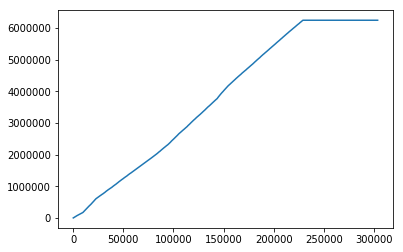

In [262]:
plt.plot(spend)

In [21]:
# best
# get our bid price
XG_test = pd.read_csv('we_data/XG_test.csv') # using XGboosting to predict the CTR
basebid = 600
bidprice = LinearStrategy(XG_test, basebid, avgCTR)
bidprice[:50000] = bidprice[:50000] /10

Group_17 = pd.DataFrame(data = list(zip(test["bidid"], bidprice)), columns = ["bidid", "bidprice"])
Group_17.to_csv("Group17.csv")

<font face="Tahoma" size=5 color=#000000> Remove expensive bidding

In [119]:
# get our bid price
XG_test = pd.read_csv('we_data/XG_test.csv') # using XGboosting to predict the CTR
basebid = 450
bidprice = LinearStrategy(XG_test, basebid, avgCTR)
bidprice[bidprice>700] = bidprice[bidprice>700] /100

Group_17 = pd.DataFrame(data = list(zip(test["bidid"], bidprice)), columns = ["bidid", "bidprice"])
Group_17.to_csv("Group17.csv")

<font face="Tahoma" size=5 color=#000000> Non-linear bidding

In [44]:
XG_test = pd.read_csv('we_data/XG_test.csv') 
bidprice = pd.read_csv('we_data/nonlinear.csv')['bidprice']
bidprice[XG_test['pCTR']<0.005] = bidprice[XG_test['pCTR']<0.005]

Group_17 = pd.DataFrame(data = list(zip(test["bidid"], bidprice)), columns = ["bidid", "bidprice"])
Group_17.to_csv("Group17.csv")

In [40]:
XG_test['pCTR']<0.005

0         False
1         False
2          True
3         False
4         False
5         False
6         False
7         False
8          True
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20         True
21        False
22        False
23        False
24         True
25        False
26        False
27        False
28        False
29         True
          ...  
303345    False
303346    False
303347    False
303348    False
303349    False
303350    False
303351    False
303352    False
303353    False
303354    False
303355    False
303356    False
303357    False
303358    False
303359    False
303360    False
303361    False
303362    False
303363    False
303364    False
303365    False
303366    False
303367    False
303368    False
303369    False
303370    False
303371    False
303372    False
303373    False
303374     True
Name: pCTR, Length: 3033

In [21]:
XG_test = pd.read_csv('we_data/XG_test.csv') 

In [32]:
XG_test['pCTR'].sort_values()[0:20000]

6321      0.000250
79472     0.000282
8637      0.000284
8389      0.000296
37148     0.000348
33840     0.000351
4738      0.000376
75650     0.000379
80023     0.000387
220961    0.000405
161878    0.000405
65572     0.000412
81956     0.000412
9307      0.000422
3829      0.000430
2975      0.000434
31439     0.000437
221635    0.000439
60186     0.000450
91933     0.000455
56404     0.000459
78284     0.000461
27225     0.000465
22926     0.000475
33260     0.000489
6292      0.000494
106543    0.000501
275638    0.000503
71863     0.000503
7004      0.000505
            ...   
75002     0.004147
297864    0.004147
76452     0.004147
24539     0.004147
128957    0.004147
250078    0.004147
94628     0.004147
97599     0.004147
155643    0.004147
138375    0.004147
190595    0.004147
282006    0.004147
194378    0.004147
219266    0.004147
157482    0.004147
222483    0.004148
178917    0.004148
36789     0.004148
37431     0.004148
270263    0.004148
289929    0.004148
224881    0.